# Portfolio Exercise 4, Methods 3, 2021, autumn semester
Alina Kereszt

13.12.2021

**NB! The code contained within this portfolio was developed by the study group in collaboration (Mie Søgaard (M.S.), Linus Backström (L.B.), Mikkel Kristensen (M.K.), Alina Kereszt (A.K.)). The overall responsible individual for each section is indicated with initials in the beginning. Variables, code organization and explanations may vary between the study group members as they are individually created, as well as members may have additional material in their portfolio.**

# Exercises and objectives

1) Use principal component analysis to improve the classification of subjective experience  
2) Use logistic regression with cross-validation to find the optimal number of principal components  


REMEMBER: In your report, make sure to include code that can reproduce the answers requested in the exercises below (__MAKE A KNITTED VERSION__)  
REMEMBER: This is Assignment 4 and will be part of your final portfolio

In [4]:
# load packages
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
np.random.seed(420)

## EXERCISE 1 - Use principal component analysis to improve the classification of subjective experience

We will use the same files as we did in Assignment 3
The files `megmag_data.npy` and `pas_vector.npy` can be downloaded here (http://laumollerandersen.org/data_methods_3/megmag_data.npy) and here (http://laumollerandersen.org/data_methods_3/pas_vector.npy)  
The function `equalize_targets` is supplied - this time, we will only work with an equalized data set. One motivation for this is that we have a well-defined chance level that we can compare against. Furthermore, we will look at a single time point to decrease the dimensionality of the problem  

### 1) Create a covariance matrix, find the eigenvectors and the eigenvalues (M.S.)
**i. Load `megmag_data.npy` and call it `data` using `np.load`. You can use `join`, which can be imported from `os.path`, to create paths from different string segments** 

In [5]:
data = np.load('megmag_data.npy') 
y = np.load('pas_vector.npy') # load data

**ii. Equalize the number of targets in `y` and `data` using `equalize_targets`**

In [6]:
def equalize_targets(data, y):
    np.random.seed(7)
    targets = np.unique(y)
    counts = list()
    indices = list()
    for target in targets:
        counts.append(np.sum(y == target))
        indices.append(np.where(y == target)[0])
    min_count = np.min(counts)
    first_choice = np.random.choice(indices[0], size=min_count, replace=False)
    second_choice = np.random.choice(indices[1], size=min_count, replace=False)
    third_choice = np.random.choice(indices[2], size=min_count, replace=False)
    fourth_choice = np.random.choice(indices[3], size=min_count, replace=False)
    
    new_indices = np.concatenate((first_choice, second_choice,
                                 third_choice, fourth_choice))
    new_y = y[new_indices]
    new_data = data[new_indices, :, :]
    
    return new_data, new_y
  
equalized = equalize_targets(data, y)
X_equal = equalized[0]
y_equal = equalized[1]

**iii. Construct `times=np.arange(-200, 804, 4)` and find the index corresponding to 248 ms - then reduce the dimensionality of `data` from three to two dimensions by only choosing the time index corresponding to 248 ms (248 ms was where we found the maximal average response in Assignment 3)** 

In [7]:
times = np.arange(-200, 804, 4)
index_248ms = np.where(times == 248)
X_248ms = X_equal[:, :, index_248ms[0]]
X_248ms = np.reshape(X_248ms, (396, 102)) # the shape was a bit weird, 
# had to remove an extra dimension with no values

**iv. Scale the data using `StandardScaler`**  

In [8]:
sc = StandardScaler()
X_248ms_std = sc.fit_transform(X_248ms)

**v. Calculate the sample covariance matrix for the sensors (you can use `np.cov`) and plot it (either using `plt.imshow` or `sns.heatmap` (`import seaborn as sns`))** 

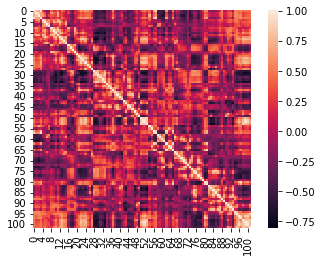

In [9]:
covmat = np.cov(X_248ms_std, rowvar = False)

plt.figure()
sns.heatmap(covmat, square = True) 
plt.show()

**vi. What does the off-diagonal activation imply about the independence of the signals measured by the 102 sensors?**  

It implies that the measurements by the sensors are not entirely independent of each other, meaning that if we took the measurements from all sensors into account, we would be modeling a significant amount of noise (and thereby hurting our prediction accuracy).

**vii. Run `np.linalg.matrix_rank` on the covariance matrix - what integer value do you get? (we'll use this later)**  

In [10]:
# matrix rank is the number of linearly independent rows or 
# columns in the matrix
matrix_rank = np.linalg.matrix_rank(covmat)
matrix_rank

97

**viii. Find the eigenvalues and eigenvectors of the covariance matrix using `np.linalg.eig` - note that some of the numbers returned are complex numbers, consisting of a real and an imaginary part (they have a _j_ next to them). We are going to ignore this by only looking at the real parts of the eigenvectors and -values. Use `np.real` to retrieve only the real parts**  

In [11]:
# Eigenvalues and eigenvectors are basically just a decomposition 
# of a square matrix; in essence you break the matrix down into 
# its constituent parts so that it it easier to perform operations 
# on it
# One such operation is the reduction of dimensionality, i.e. 
# removing variables that are just noise
eigenvalues, eigenvectors = np.linalg.eig(covmat)
# eigen = np.linalg.eig(covmat)
# eigenvalues = eigen[0]
# eigenvectors = eigen[1]
eigenvalues = np.real(eigenvalues)
eigenvectors = np.real(eigenvectors)

### 2) Create the weighting matrix $W$ and the projected data, $Z$ (L.B.)
**i. We need to sort the eigenvectors and eigenvalues according to the absolute values of the eigenvalues (use `np.abs` on the eigenvalues).**  

In [12]:
eigenvalues_abs = np.abs(eigenvalues) # find the absolute 
# values of the eigenvalues

**ii. Then, we will find the correct ordering of the indices and create an array, e.g. `sorted_indices` that contains these indices. We want to sort the values from highest to lowest. For that, use `np.argsort`, which will find the indices that correspond to sorting the values from lowest to highest. Subsequently, use `np.flip`, which will reverse the order of the indices.**  

In [13]:
# 'np.argsort' is an indirect sort; it sorts the indices 
# of the values rather than the values themselves
sorted_indices = np.argsort(eigenvalues_abs)
sorted_indices = np.flip(sorted_indices)

**iii. Finally, create arrays of sorted eigenvalues and eigenvectors using the `sorted_indices` array just created. For the eigenvalues, it should like this `eigenvalues = eigenvalues[sorted_indices]` and for the eigenvectors: `eigenvectors = eigenvectors[:, sorted_indices]`**

In [14]:
eigenvalues = eigenvalues[sorted_indices]

**iv. Plot the log, `np.log`, of the eigenvalues, `plt.plot(np.log(eigenvalues), 'o')` - are there some values that stand out from the rest? In fact, 5 (noise) dimensions have already been projected out of the data - how does that relate to the matrix rank (Exercise 1.1.vii)** 

In [15]:
np.log(eigenvalues) # demonstrate that 4 eigenvalues do not 
# have a natural logarithm

array([  3.35674527,   2.78212014,   2.48213471,   1.96283254,
         1.87756779,   1.27117459,   1.1839596 ,   1.01048866,
         0.948959  ,   0.72238718,   0.5700768 ,   0.28292523,
         0.09604088,   0.04305278,  -0.05864892,  -0.16988542,
        -0.27964178,  -0.42950715,  -0.50004516,  -0.62360666,
        -0.70384654,  -0.91615604,  -1.03417312,  -1.10980711,
        -1.17297602,  -1.23151451,  -1.32730589,  -1.36219089,
        -1.40232561,  -1.44736119,  -1.53346189,  -1.55341719,
        -1.59666964,  -1.69768001,  -1.72256598,  -1.80960706,
        -1.91363889,  -1.94362535,  -1.95069178,  -2.00087052,
        -2.03933315,  -2.08101912,  -2.0976541 ,  -2.17395025,
        -2.20176023,  -2.26938203,  -2.30012474,  -2.33705031,
        -2.38338011,  -2.41725376,  -2.43001836,  -2.4791752 ,
        -2.53186376,  -2.58136232,  -2.59020077,  -2.61808854,
        -2.63452201,  -2.68200561,  -2.72877278,  -2.74791774,
        -2.81523991,  -2.86253059,  -2.87602846,  -2.89

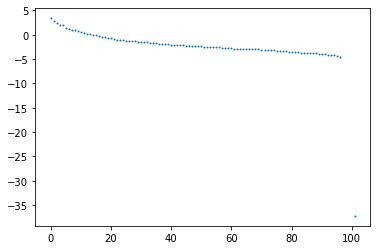

In [16]:
plt.figure()
plt.plot(np.log(eigenvalues), 'o', markersize = 1)
plt.show()

When evaluating matrix rank, we found that there were 97 linearly independent rows or columns in the matrix, i.e. 102 - 97 = 5 that *aren't* linearly independent - the measurements from that sensor correlate perfectly with the measurements from another sensor. This is also illustrated by taking the natural logarithm of the eigenvalues: 4 eigenvalues are negative, meaning that they do not possess a natural logarithm, while the 5th has a natural logarithm that is significantly different from that of the other eigenvalues.

**v. Create the weighting matrix, `W` (it is the sorted eigenvectors)** 

In [17]:
W = eigenvectors[:, sorted_indices]

**vi. Create the projected data, `Z`, $Z = XW$ - (you can check you did everything right by checking whether the $X$ you get from $X = ZW^T$ is equal to your original $X$, `np.isclose` may be of help)**

In [18]:
Z = X_248ms_std @ W

# verify that I have done it correctly
X_check = Z @ W.T
check = np.isclose(X_248ms_std, X_check)
np.unique(check) # only matches - yay!

array([ True])

**vii. Create a new covariance matrix of the principal components (n = 102) - plot it! What has happened off-diagonal and why?**

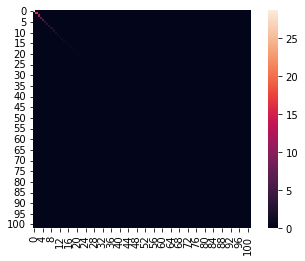

In [19]:
covmat2 = np.cov(Z, rowvar = False)

plt.figure()
sns.heatmap(covmat2, square = True)
plt.show()

There is no longer any covariance between the dimensions off-diagonal (the vectors for each principal component have been multiplied by the sorted eigenvectors, yielding a dot product of 0). 

## EXERCISE 2 - Use logistic regression with cross-validation to find the optimal number of principal components  
### 1) We are going to run logistic regression with in-sample validation (A.K.)
**i. First, run standard logistic regression (no regularization) based on $Z_{d \times k}$ and `y` (the target vector). Fit (`.fit`) 102 models based on: $k = [1, 2, ..., 101, 102]$ and $d = 102$. For each fit get the classification accuracy, (`.score`), when applied to $Z_{d \times k}$ and $y$. This is an in-sample validation. Use the solver `newton-cg` if the default solver doesn't converge**

In [20]:
logR = LogisticRegression(penalty = 'none', solver = 'newton-cg')
scores = np.zeros(shape = (102))
for i in range(102):
  if i == 0:
    X = Z[:, 0]
    X = X.reshape(-1, 1)
  elif i == 102:
    X = Z[:, :]
  else:
    X = Z[:, 0 : i + 1] # python is a bit fussy about ranges 
    # and couldn't deal with the first and last 'i' on its own
  logm = logR.fit(X, y_equal)
  score = logm.score(X, y_equal)
  scores[i] = score

**ii. Make a plot with the number of principal components on the _x_-axis and classification accuracy on the _y_-axis - what is the general trend and why is this so?**

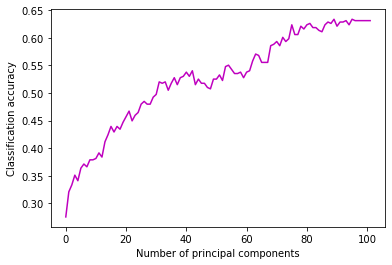

In [21]:
plt.figure()
plt.plot(scores, color = 'm')
plt.xlabel('Number of principal components')
plt.ylabel('Classification accuracy')
plt.show()

Classification accuracy generally increases as we add more components. Since we are validating our model in-sample (we aren't testing generalizability to a new dataset), overfitting is not penalized and more dimensions conform better to the data.

**iii. In terms of classification accuracy, what is the effect of adding the five last components? Why do you think this is so?**

In [22]:
scores[-6:-1] # retrieve the scores for the regressions 
# involving the last 5 components

array([0.63131313, 0.63131313, 0.63131313, 0.63131313, 0.63131313])

The classification accuracy does not increase when adding the last five components. This is because they are linearly dependent on other components, and therefore don't supply any extra information.

### 2) Now, we are going to use cross-validation - we are using `cross_val_score` and `StratifiedKFold` from `sklearn.model_selection` (M.S.)
**i. Define the variable: `cv = StratifiedKFold()` and run `cross_val_score` (remember to set the `cv` argument to your created `cv` variable). Use the same `estimator` in `cross_val_score` as in Exercise 2.1.i. Find the mean score over the 5 folds (the default of `StratifiedKFold`) for each $k$, $k = [1, 2, ..., 101, 102]$**  

In [23]:
logR = LogisticRegression(penalty = 'none', solver = 'newton-cg')
cv = StratifiedKFold(n_splits = 5)

scores = np.zeros(shape = (102))
for i in range(102):
  if i == 0:
    X = Z[:, 0]
    X = X.reshape(-1, 1)
  elif i == 102:
    X = Z[:, :]
  else:
    X = Z[:, 0 : i + 1] # python is a bit fussy about ranges 
    # and couldn't deal with the first and last 'i' on its own
  logm = logR.fit(X, y_equal)
  score = cross_val_score(logm, X, y_equal, cv = cv)
  mean = np.mean(score) # take average of the 5 folds
  scores[i] = mean

**ii. Make a plot with the number of principal components on the _x_-axis and classification accuracy on the _y_-axis - how is this plot different from the one in Exercise 2.1.ii?**

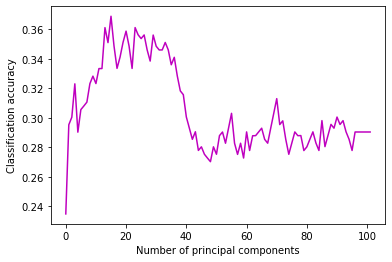

In [24]:
plt.figure()
plt.plot(scores, color = 'm')
plt.xlabel('Number of principal components')
plt.ylabel('Classification accuracy')
plt.show()

Here, after the addition of a certain amount of principal components, classification accuracy actually diminishes. This is because we are now splitting our data into training and validation sets, 5 times, thereby making sure that the model can be generalized to new data. Overfitting by adding an excess amount of principal components is thereby penalized: the model has to represent the general trends in the data, rather than conform to each individual data point.

**iii. What is the number of principal components, $k_{max\_accuracy}$, that results in the greatest classification accuracy when cross-validated?** 

In [25]:
max_accuracy_index = np.argmax(scores)
max_accuracy_index + 1 # since index 0 denotes 1 component, 
# index 15 denotes 16 components

16

**iv. How many percentage points is the classification accuracy increased with relative to the to the full-dimensional, $d$, dataset**

In [26]:
scores[max_accuracy_index] - scores[-1]

0.07851265822784809

The classification accuracy increased by 7.8 percentage points.

**v. How do the analyses in Exercises 2.1 and 2.2 differ from one another? Make sure to comment on the differences in optimization criteria.**

In Exercise 2.1, the model is optimized to best represent the data that is available. Validation is done in-sample, i.e. performed on the data that was used to create the model, which means that overfitting isn't penalized.

In Exercise 2.2, the model is optimized to be generalizable to new data. With cross-validation, we split the data into an equal number of folds, always successively reserving one fold to use for validation and fitting the model on the remaining folds; i.e. in a sense, we are validating the model out-of-sample, on new data. Overfitting is thus penalized.
    
### 3) We now make the assumption that $k_{max\_accuracy}$ is representative for each time sample (we only tested for 248 ms). We will use the PCA implementation from _scikit-learn_, i.e. import `PCA` from `sklearn.decomposition`. (M.K.)

**i. For __each__ of the 251 time samples, use the same estimator and cross-validation as in Exercises 2.1.i and 2.2.i. Run two analyses - one where you reduce the dimensionality to $k_{max\_accuracy}$ dimensions using `PCA` and one where you use the full data. Remember to scale the data (for now, ignore if you get some convergence warnings - you can try to increase the number of iterations, but this is not obligatory)** 

In [27]:
# MAX ACCURACY
pca = PCA(n_components = 15)
scores_max = np.zeros(shape = (251))
logR = LogisticRegression(penalty = 'none', solver = 'newton-cg')
cv = StratifiedKFold(n_splits = 5)
sc = StandardScaler()

for i in range(251):
  X_time = X_equal[:, :, i]
  X_time_std = sc.fit_transform(X_time)
  X_pca = pca.fit_transform(X_time_std)
  logm = logR.fit(X_pca, y_equal)
  score = cross_val_score(logm, X_pca, y_equal, cv = cv)
  mean = np.mean(score)
  scores_max[i] = mean

# ALL THE DATA
scores_all = np.zeros(shape = (251))
logR = LogisticRegression(penalty = 'none', solver = 'newton-cg')
cv = StratifiedKFold(n_splits = 5)
sc = StandardScaler()

for i in range(251):
  X_time = X_equal[:, :, i]
  X_time_std = sc.fit_transform(X_time)
  logm = logR.fit(X_time_std, y_equal)
  score = cross_val_score(logm, X_time_std, y_equal, cv = cv)
  mean = np.mean(score)
  scores_all[i] = mean

**ii. Plot the classification accuracies for each time sample for the analysis with PCA and for the one without in the same plot. Have time (ms) on the _x_-axis and classification accuracy on the _y_-axis**

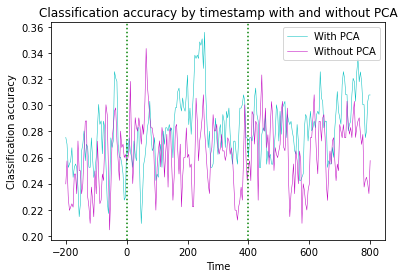

In [29]:
plt.figure()
plt.plot(times, scores_max, color = 'c', linewidth = .5)
plt.plot(times, scores_all, color = 'm', linewidth = .5)
plt.axvline(x = 0, color = 'g', linestyle = ':')
plt.axvline(x = 400, color = 'g', linestyle = ':')
plt.title('Classification accuracy by timestamp with and without PCA')
plt.xlabel('Time')
plt.ylabel('Classification accuracy')
plt.legend(['With PCA', 'Without PCA'])
plt.show()

**iii. Describe the differences between the two analyses - focus on the time interval between 0 ms and 400 ms - describe in your own words why the logistic regression performs better on the PCA-reduced dataset around the peak magnetic activity**

Since we are optimizing this model to be generalizable to new data, it is important that it capture the general trends in the data rather than be overfitted. By conducting principle component analysis (PCA), we can find the components that are most influential in describing these general trends; to add less components would be to discard useful information, but to add more would be to introduce noise and risk fitting the model to this noise.

It overall seems that the PCA-reduced dataset performs better on the time interval between 0 ms and 400 ms; this is true in particular around the peak magnetic activity, as this is the timepoint at which the analysis was conducted.